In [1]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Unzip the dataset
#with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
#    zip_ref.extractall()

In [3]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n01443537/
            n01443537_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n01641577/
            n01641577_boxes.txt
            images/
                Number of JPEG files: 500
        n01644900/
            n01644900_boxes.txt
            images/
                Number of JPEG files: 500
        n01698640/
            n01698640_boxes.txt
            images/
                Number of JPEG files: 500
        n01742172/
            n01742172_boxes.txt
            images/
                Number of JPEG files: 500
        n01768244/
            n01768244_boxes.txt
            images/
                Number of JPEG files: 500
        n01770393/
            n01770393_boxes.txt
            images/
              

In [4]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Read the wnids from wnids.txt into a set
with open('./tiny-imagenet-200/wnids.txt') as f:
    wnids = {line.strip() for line in f}

# Filter wnid_labels to only include the wnids in Tiny ImageNet
wnid_labels = {wnid: desc for wnid, desc in wnid_labels.items() if wnid in wnids}

len(wnid_labels) # We only want the mappings that are in tinynet

200

In [5]:
# Define the function to randomly sample n images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [6]:
# Define the function to sample n images by wordnet-id
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [7]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

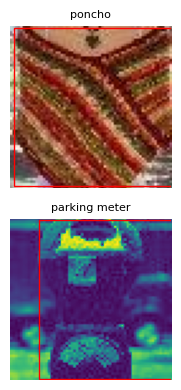

In [8]:
display_images(rsample_images(2))

In [9]:
#display_images(sample_images_by_wnid('n02099601',2))

In [30]:
# Here's how you can create a DataLoader for your dataset. Remember, this code won't run in this environment but you can use it as a template in your local environment:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load Tiny ImageNet dataset
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform)
val_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform)



# Create data loaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [31]:
len(train_loader)

1000

In [11]:
# Inspect a batch from train_loader
train_images, train_labels = next(iter(train_loader))
print("Train images batch shape:", train_images.shape)
print("Train labels batch shape:", train_labels.shape)
print("Train images data type:", train_images.dtype)
print("Train labels data type:", train_labels.dtype)

# Inspect a batch from val_loader
val_images, val_labels = next(iter(val_loader))
print("Validation images batch shape:", val_images.shape)
print("Validation labels batch shape:", val_labels.shape)
print("Validation images data type:", val_images.dtype)
print("Validation labels data type:", val_labels.dtype)


Train images batch shape: torch.Size([256, 3, 64, 64])
Train labels batch shape: torch.Size([256])
Train images data type: torch.float32
Train labels data type: torch.int64
Validation images batch shape: torch.Size([256, 3, 64, 64])
Validation labels batch shape: torch.Size([256])
Validation images data type: torch.float32
Validation labels data type: torch.int64


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input channels = 3, output channels = 6, kernel size = 5
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input channels = 6, output channels = 16, kernel size = 5
        self.fc1 = nn.Linear(16 * 13 * 13, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 200)  # 200 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling
        x = x.view(-1, 16 * 13 * 13)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected -> ReLU
        x = F.relu(self.fc2(x))  # Fully connected -> ReLU
        x = self.fc3(x)  # Fully connected
        return x


In [13]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % batch_size == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {100*(correct / total):.2f}%')

        print(f'End of Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(loss_list):.4f}, Accuracy: {100*np.mean(acc_list):.2f}%')
        loss_list = []
        acc_list = []

In [14]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer for our CNN
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10
train_model(cnn_model, train_loader, criterion, optimizer, num_epochs)

# Assume model is your trained model
torch.save(cnn_model.state_dict(), "cnn_model_parameters.pth")

Epoch [1/10], Step [100/1000], Loss: 5.3119, Accuracy: 0.00%
Epoch [1/10], Step [200/1000], Loss: 5.3018, Accuracy: 0.00%
Epoch [1/10], Step [300/1000], Loss: 5.2678, Accuracy: 1.00%
Epoch [1/10], Step [400/1000], Loss: 5.2501, Accuracy: 1.00%
Epoch [1/10], Step [500/1000], Loss: 5.0971, Accuracy: 1.00%
Epoch [1/10], Step [600/1000], Loss: 4.9575, Accuracy: 4.00%
Epoch [1/10], Step [700/1000], Loss: 4.9792, Accuracy: 4.00%
Epoch [1/10], Step [800/1000], Loss: 4.8724, Accuracy: 4.00%
Epoch [1/10], Step [900/1000], Loss: 4.9053, Accuracy: 3.00%
Epoch [1/10], Step [1000/1000], Loss: 4.9224, Accuracy: 3.00%
End of Epoch [1/10], Loss: 5.1272, Accuracy: 1.76%
Epoch [2/10], Step [100/1000], Loss: 4.7293, Accuracy: 7.00%
Epoch [2/10], Step [200/1000], Loss: 4.4156, Accuracy: 9.00%
Epoch [2/10], Step [300/1000], Loss: 4.6832, Accuracy: 7.00%
Epoch [2/10], Step [400/1000], Loss: 4.7031, Accuracy: 5.00%
Epoch [2/10], Step [500/1000], Loss: 4.6779, Accuracy: 5.00%
Epoch [2/10], Step [600/1000], Lo

In [15]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model_adam = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Adam as the optimizer for our CNN
optimizer = optim.Adam(cnn_model_adam.parameters(), lr=0.001)
num_epochs = 10
train_model(cnn_model_adam, train_loader, criterion, optimizer, num_epochs) # optimizer changed to adam

# Assume model is your trained model
torch.save(cnn_model_adam.state_dict(), "cnn_model_adam_parameters.pth")

Epoch [1/10], Step [100/1000], Loss: 5.1705, Accuracy: 2.00%
Epoch [1/10], Step [200/1000], Loss: 4.9800, Accuracy: 3.00%
Epoch [1/10], Step [300/1000], Loss: 5.0141, Accuracy: 2.00%
Epoch [1/10], Step [400/1000], Loss: 4.8542, Accuracy: 5.00%
Epoch [1/10], Step [500/1000], Loss: 4.8584, Accuracy: 6.00%
Epoch [1/10], Step [600/1000], Loss: 4.7859, Accuracy: 4.00%
Epoch [1/10], Step [700/1000], Loss: 4.6075, Accuracy: 6.00%
Epoch [1/10], Step [800/1000], Loss: 4.4705, Accuracy: 6.00%
Epoch [1/10], Step [900/1000], Loss: 4.3887, Accuracy: 15.00%
Epoch [1/10], Step [1000/1000], Loss: 4.2979, Accuracy: 13.00%
End of Epoch [1/10], Loss: 4.7770, Accuracy: 4.84%
Epoch [2/10], Step [100/1000], Loss: 4.3200, Accuracy: 9.00%
Epoch [2/10], Step [200/1000], Loss: 4.2347, Accuracy: 11.00%
Epoch [2/10], Step [300/1000], Loss: 3.9695, Accuracy: 14.00%
Epoch [2/10], Step [400/1000], Loss: 3.9513, Accuracy: 16.00%
Epoch [2/10], Step [500/1000], Loss: 4.2934, Accuracy: 7.00%
Epoch [2/10], Step [600/1000

#### Observations:
Notice how much faster `optim.Adam(lr=0.001)` converges at first compared to `optim.SGD(lr=0.01)`!

Note: We still have yet to validate these trained models. They could still just be overfitting to gain accuracy, we will need to investigate these trained models results on the val dataset!

I tried to run Adam at lr=0.01 but it wouldn't converge at all.

Running for 30 epochs each on my MacBook Air w/ M1 chip takes 48 minutes.

Time to move to the Nvidia 4090

Running for 30 epochs each on my Nvidia 4090 GPU takes 14 minutes with SGD and 12 minutes with Adam.

Each time `optim.Adam(lr=0.001)` seemed slow to reach similar accuracies that `optim.SGD(lr=0.01)` was making.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=200):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion*2*2, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [32]:
model = ResNet18()
#model.load_state_dict(torch.load("model_parameters.pth")) # comment out to train fresh model

criterion = nn.CrossEntropyLoss()  # Common choice for of loss for classification problems
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Common choice of optimizer for CNNs

# Ensure we are on cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We are running on {device}.")
# Define number of epochs to train
num_epochs = 15  # Adjust as needed

# Call the training function
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Assume model is your trained model
torch.save(model.state_dict(), "model_parameters.pth")


We are running on cuda.
Epoch [1/15], Step [100/1000], Loss: 5.1376, Accuracy: 2.00%
Epoch [1/15], Step [200/1000], Loss: 4.6929, Accuracy: 4.00%
Epoch [1/15], Step [300/1000], Loss: 4.4505, Accuracy: 6.00%
Epoch [1/15], Step [400/1000], Loss: 4.0581, Accuracy: 8.00%
Epoch [1/15], Step [500/1000], Loss: 4.1619, Accuracy: 13.00%
Epoch [1/15], Step [600/1000], Loss: 4.2453, Accuracy: 6.00%
Epoch [1/15], Step [700/1000], Loss: 3.6624, Accuracy: 18.00%
Epoch [1/15], Step [800/1000], Loss: 3.9465, Accuracy: 15.00%
Epoch [1/15], Step [900/1000], Loss: 3.6836, Accuracy: 19.00%
Epoch [1/15], Step [1000/1000], Loss: 3.7979, Accuracy: 11.00%
End of Epoch [1/15], Loss: 4.2312, Accuracy: 11.59%
Epoch [2/15], Step [100/1000], Loss: 3.7687, Accuracy: 16.00%
Epoch [2/15], Step [200/1000], Loss: 3.3599, Accuracy: 21.00%
Epoch [2/15], Step [300/1000], Loss: 3.4433, Accuracy: 20.00%
Epoch [2/15], Step [400/1000], Loss: 3.2604, Accuracy: 22.00%
Epoch [2/15], Step [500/1000], Loss: 3.1681, Accuracy: 28.00

In [33]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # We don't need gradients for evaluation
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    print(f'Final Validation accuracy: {100 * correct / total}%, Final Validation loss: {total_loss / len(val_loader)}')

#### CNN-Model w/ SGD

In [34]:
# Load the trained model parameters
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load("cnn_model_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(cnn_model, val_loader, criterion, device)

Final Validation accuracy: 16.95%, Final Validation loss: 3.9324752354621886


#### CNN-Model w/ Adam

In [35]:
# Load the trained model parameters
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load("cnn_model_adam_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(cnn_model, val_loader, criterion, device)

Final Validation accuracy: 18.04%, Final Validation loss: 3.767960946559906


#### Resnet-18

In [36]:
# Load the trained model parameters
model = ResNet18()
model.load_state_dict(torch.load("model_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(model, val_loader, criterion, device)

Final Validation accuracy: 48.51%, Final Validation loss: 2.78674311041832


1)  The input to the ResNet model is a batch of 100 color images, each of size 64x64 (3 color channels). The shape of this input tensor is (100, 3, 64, 64).

2)  The first operation in the ResNet model is a convolutional layer (conv1) followed by a batch normalization layer (bn1). The convolutional layer changes the number of channels in the input from 3 to 64. Hence, the output shape after this operation is (100, 64, 64, 64).

3)  The output from the above operation is then passed through the first layer (layer1) of the ResNet model, which consists of a series of BasicBlock layers.
    - Within each BasicBlock, the input first goes through a convolutional layer (conv1), a batch normalization layer (bn1), another convolutional layer (conv2), and another batch normalization layer (bn2). The number of channels remains the same (64), and the height and width of the images also remain the same (64x64) due to the padding and stride of the convolution operations. Hence, the output shape after these operations remains (100, 64, 64, 64).
    - The BasicBlock also includes a shortcut connection that allows the input to bypass the main layers and be added to the output of the block. This is part of the "residual" design of ResNet and is intended to help mitigate the problem of vanishing gradients in deep networks.
    - The output of the BasicBlock is then passed through a ReLU activation function, which introduces non-linearity into the model but does not change the shape of the tensor.
<br><br>
4)  This process is repeated for the next layers (layer2, layer3, layer4) in the ResNet model. In each of these layers, the number of channels is increased (from 64 to 128, then to 256, and finally to 512) and the height and width of the images are reduced (from 64x64 to 32x32, then to 16x16, and finally to 8x8), due to the use of stride 2 in the convolution operations in these layers.

5)  After passing through all the layers, the output tensor is then passed through an average pooling operation (avg_pool2d) that reduces the height and width of the images from 8x8 to 1x1. This results in a tensor of shape (100, 512, 1, 1).

6)  The tensor is then flattened (using view) to a shape of (100, 512).

7)  Finally, the flattened tensor is passed through a fully connected (linear) layer that reduces the size of the second dimension from 512 to the number of classes in the classification problem (200 in this case). The output shape is thus (100, 200), representing the model's predictions for the 200 classes for each of the 100 images in the batch.

### Lets investigate the difference between train loss and val loss on ResNet18
##### Perhaps we can try to shuffle up the orientations of the images during the training process so the model never technically sees the same input twice?